# DOC

数据清洗

* 缺失值填充
* 类别型变量处理
    - 将用数值表示的类别型变量转换为类别型变量
    - 将类别型变量转换为有序类别型变量
    - 将类别型变量转换为哑变量
* Box-Cox变换: 将分布为偏态分布的变量转换为近似正态分布

特征工程



回归模型

* Lasso
* XGBoost
* LightGBM

# 1. Libraries

In [41]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))

from scipy import stats
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
color = sns.color_palette()
sns.set_style("darkgrid")

# import warnings
# def ignore_warn(*args, **kwargs):
#     pass
# warning.warn = ignore_warn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import xgboost


# 2. Configuration

In [42]:
# train and test dataset path
train_path = "./data/train.csv"
test_path = "./data/test.csv"
cv_method = 5
CLASS = False
SCORE_MIN = True
best_score = 10
best_param = None
best_iter = None

# 3. Train and Test Dataset

### 3.1 读入数据及数据初步探索

In [43]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [44]:
train.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [45]:
test.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.000,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0.000,Unf,0.000,763.000,763.000,GasA,Gd,Y,SBrkr,763,892,0,1655,0.000,0.000,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.000,Fin,2.000,440.000,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [46]:
print("训练数据形状:", train.shape)
print("测试数据形状:", test.shape)

训练数据形状: (1460, 81)
测试数据形状: (1459, 80)


### 3.2 数据特殊变量(Id, SalePrice)处理

#### (1) `Id` 变量的处理

保存 train 和 test 的 `Id` 变量:

In [47]:
train_Id = train["Id"]
test_Id = test["Id"]

删除 train 和 test 的 `Id` 变量:

In [48]:
# train.drop("Id", axis = 1, inplace = True)
# test.drop("Id", axis = 1, inplace = True)

处理后的 train 和 test 的形状:

In [49]:
# print("训练数据形状:", train.shape)
# print("测试数据形状:", test.shape)

#### (2) 训练数据中目标变量 `SalePrice` 的处理

保存 train 的 `SalePrice` 变量:

In [50]:
train_target = train["SalePrice"]

删除 train 的 `SalePrice` 变量:

In [51]:
# train.drop("SalePrice", axis = 0, inplace = True)

# 4. 数据探索性分析及清洗

* 4.1 目标变量分析及处理
* 4.2 异常值检测及处理
* 4.3 缺失值检测及处理
    - 对含缺失值的数值型变量用各自特征的均值进行填充
* 4.4 数值变量分析及处理
    - 对偏态分布的数值特征进行 $log(x+1)$ 转换;
        - `np.log1p(feature)`
* 4.5 类别型变量分析及处理
    - 有序类别型变量
    - 无序类别型变量
        - 重编码, 生成哑变量(dummary variable)
            - `sklearn.preprocessing.OneHotEncoding().transformation().fit()`

## 4.1 目标变量分析及处理

In [52]:
train["SalePrice"].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

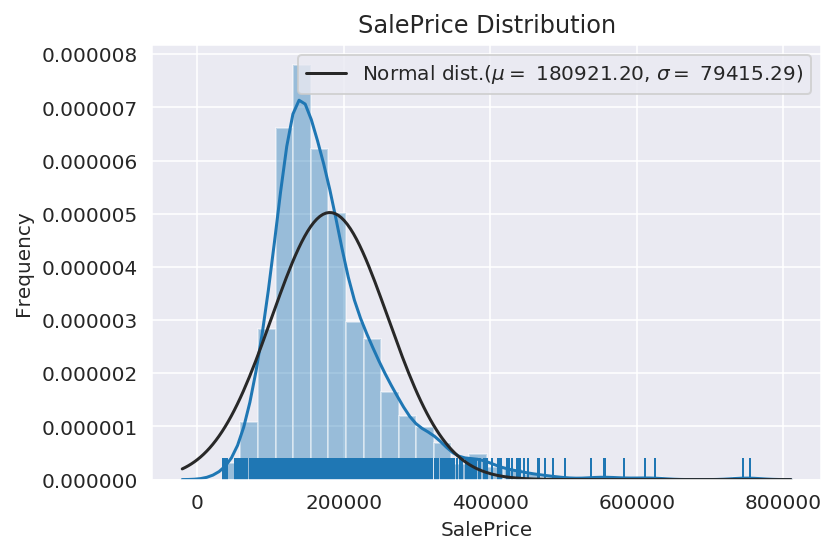

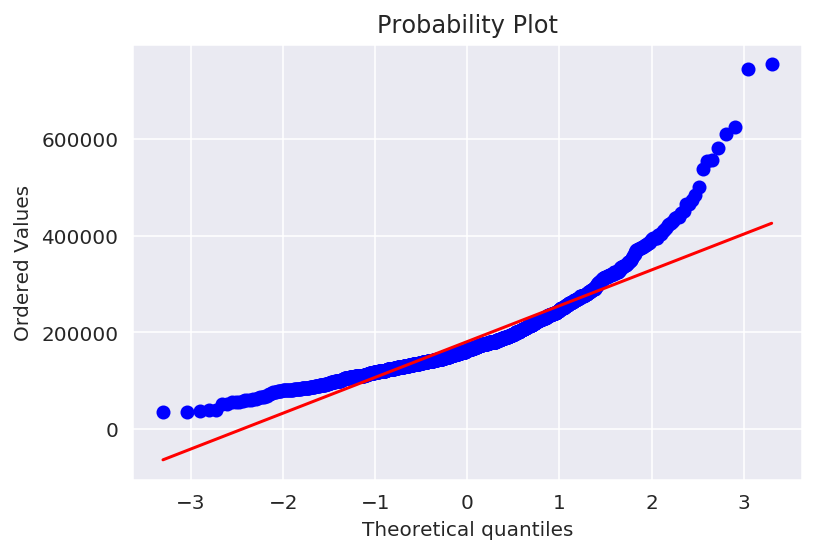

In [53]:
sns.distplot(train_target, bins = 30, hist = True, kde = True, rug = True, fit = norm)
(mu, sigma) = norm.fit(train_target)
plt.legend(["Normal dist.($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma)], 
           loc = "best")
plt.ylabel("Frequency")
plt.title("SalePrice Distribution");

# QQ-plot
fig = plt.figure()
res = stats.probplot(train_target, plot = plt)
plt.show()

* 目标变量 `SalePrice` 是右偏的
* 对 `SalePrice` 进行对数转换,使得 `SalePrice` 变得接近正态分布

In [13]:
train_target_log1p = np.log1p(train_target)

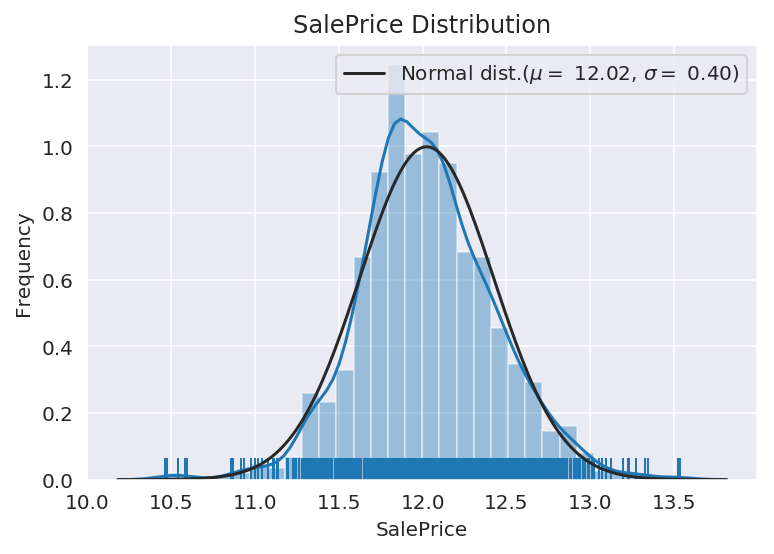

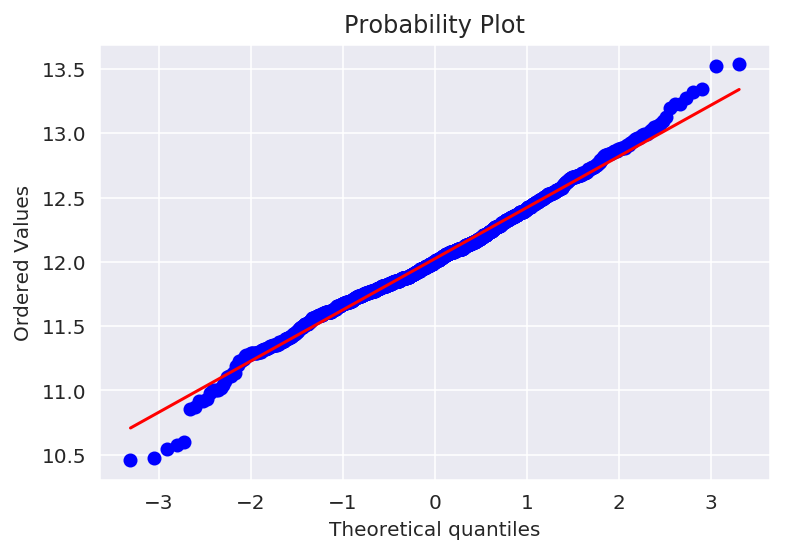

In [14]:
sns.distplot(train_target_log1p, bins = 30, hist = True, kde = True, rug = True, fit = norm)
(mu, sigma) = norm.fit(train_target_log1p)
plt.legend(["Normal dist.($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma)], 
           loc = "best")
plt.ylabel("Frequency")
plt.title("SalePrice Distribution");

# QQ-plot
fig = plt.figure()
res = stats.probplot(train_target_log1p, plot = plt)
plt.show()

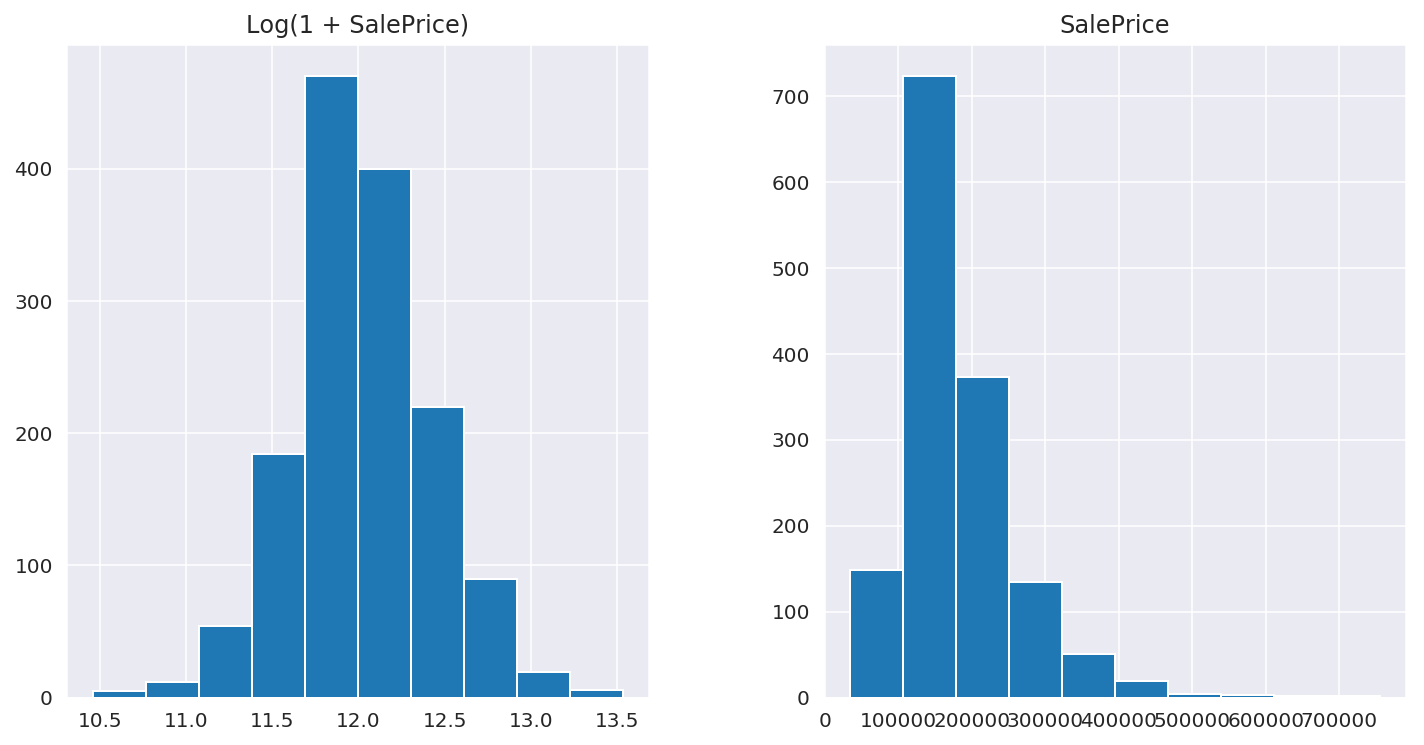

In [15]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
SalePrice_df = pd.DataFrame({
    "SalePrice": train_target,
    "Log(1 + SalePrice)": train_target_log1p
})
SalePrice_df.hist();

In [16]:
train["SalePrice"] = np.log1p(train["SalePrice"])

## 4.2 预测变量相关性分析

### 训练数据数值变量相关系数热力图

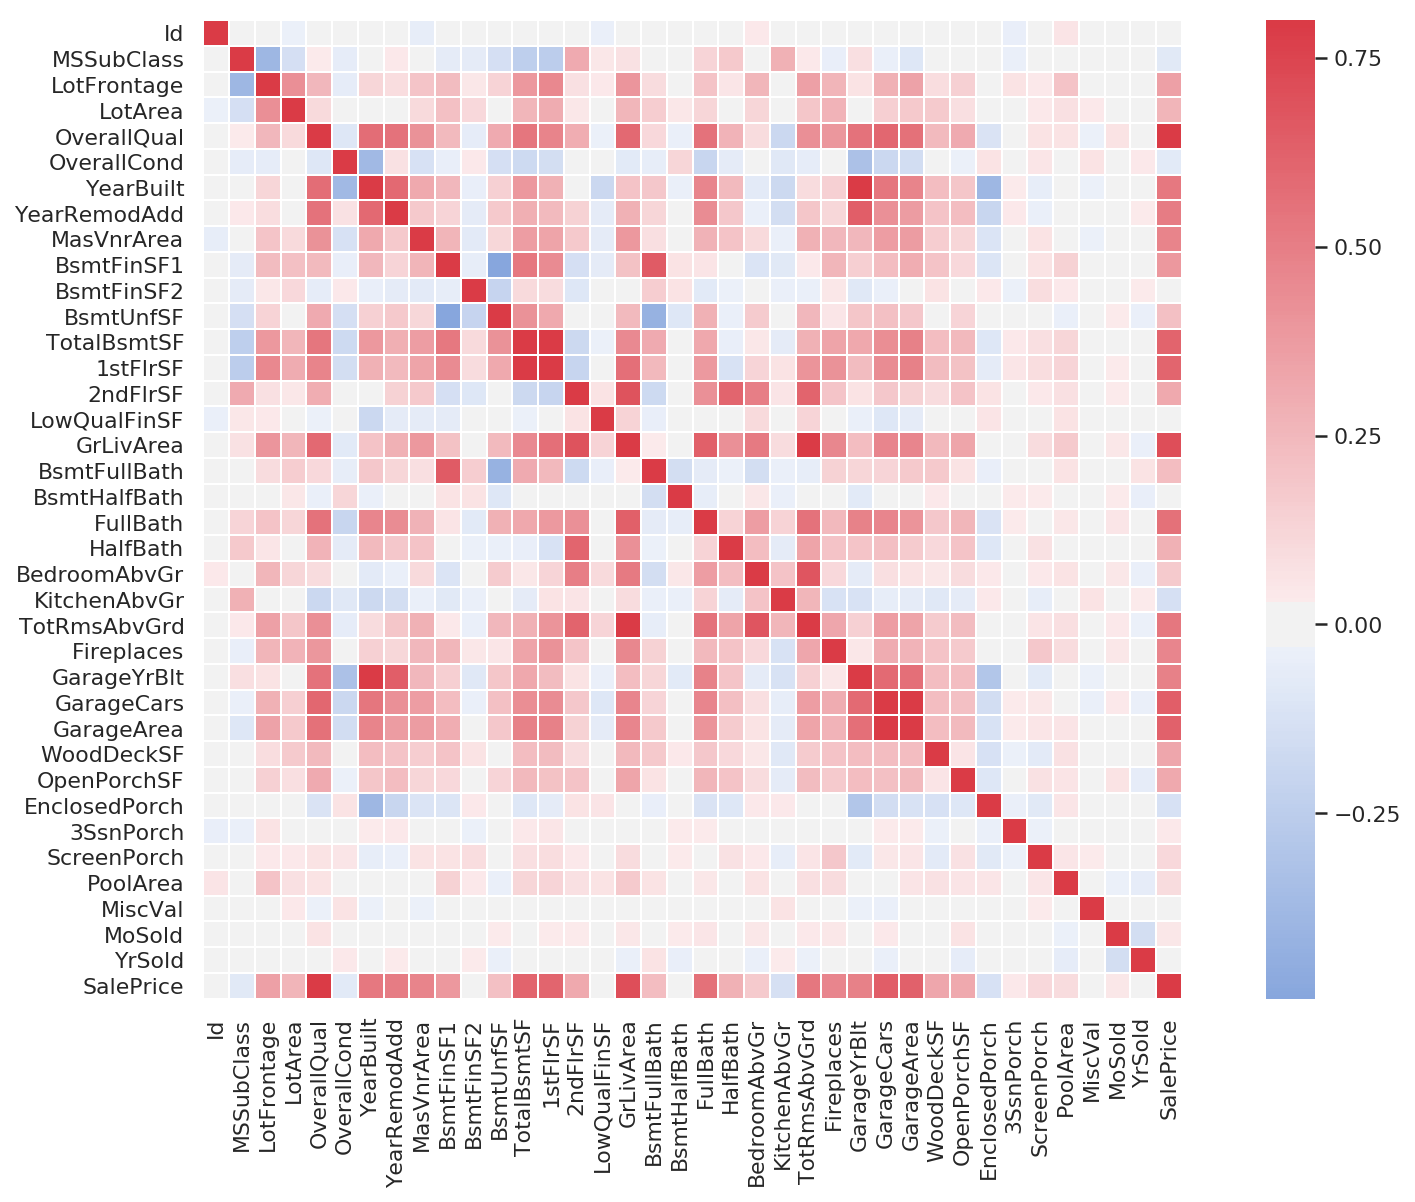

In [95]:
sns.set(style = "white")

corr_mat = train.corr()
fig, ax = plt.subplots(figsize = (12, 9))
cmap = sns.diverging_palette(255, 10, as_cmap = True)
sns.heatmap(corr_mat, 
            cmap = cmap,
            #vmin = 0,
            vmax = 0.8, 
            center = 0,
            square = True,
            linewidths = 0.5,
            #annot = True, 
            #fmt = "f"
           );

### 目标变量与数值型预测变量的相关关系热力图

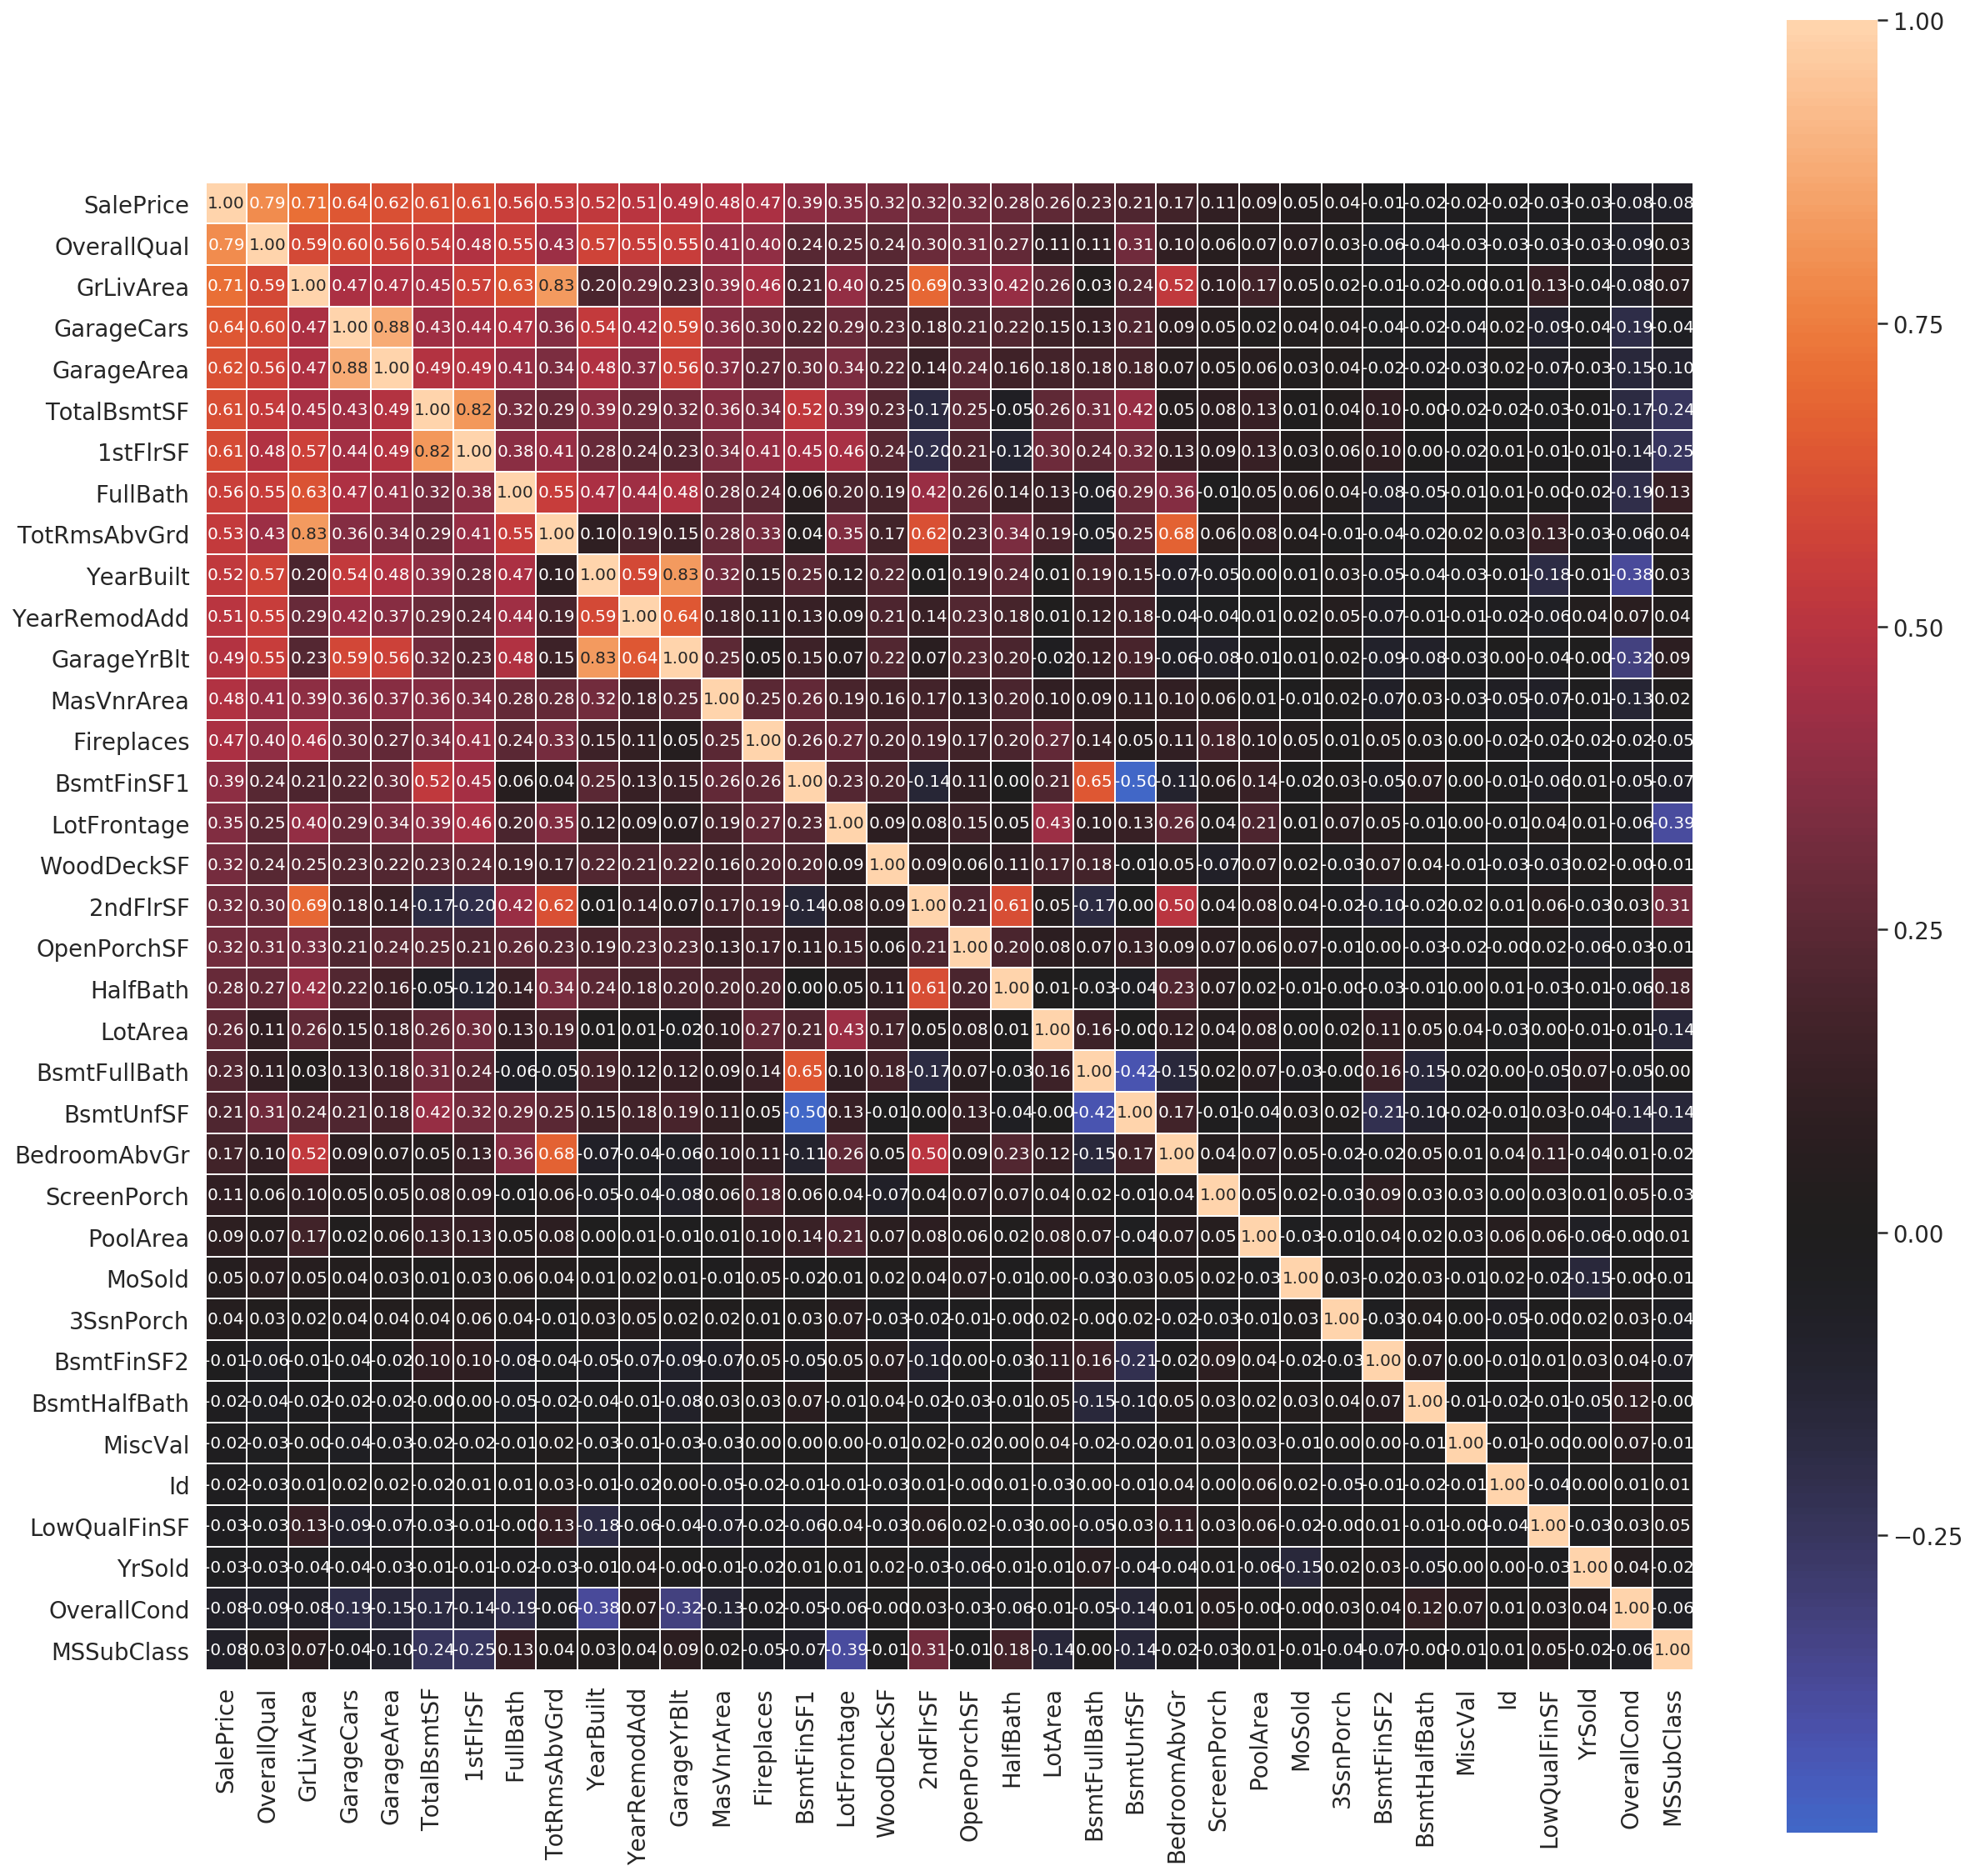

In [129]:
cols = corr_mat.nlargest(36, "SalePrice")["SalePrice"].index
sub_train = train[cols]
fig, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(sub_train.corr(),
            square = True,
            cbar = True,
            annot = True,
            fmt = ".2f",
            annot_kws = {"size": 10},
            #vmin = 0.0,
            vmax = 1.0, 
            center = 0,
            linewidths = 0.5);

## 4.2 异常值检测及处理

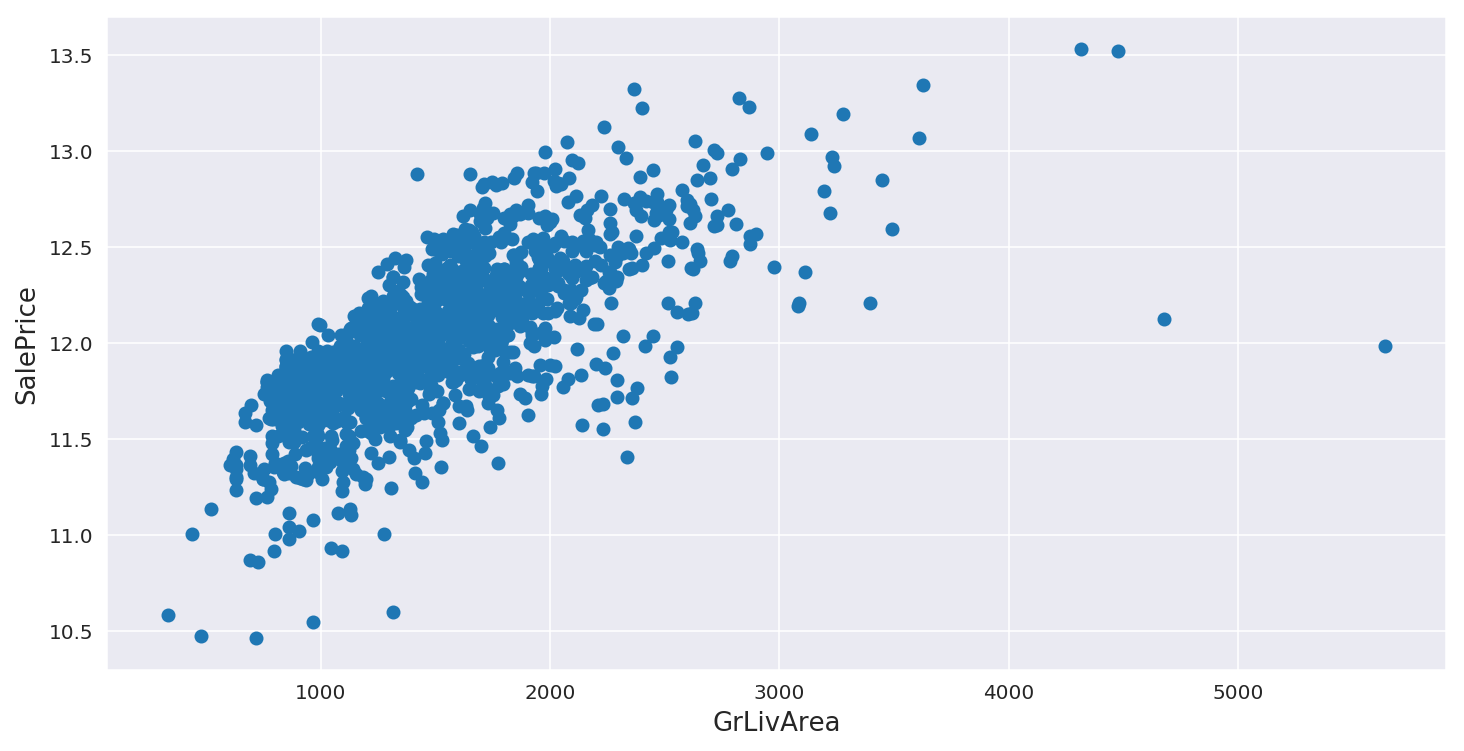

In [17]:
fig, ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train["SalePrice"])
plt.ylabel("SalePrice", fontsize = 13)
plt.xlabel("GrLivArea", fontsize = 13)
plt.show()

* 存在两个面积(GrLivArea > 4000)特别大,而价格(SalePrice < 300000)却不是很高的房子
* 认为这两个观测值属于异常值，直接将他们删除

In [18]:
outliers = train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 12.5)].index
train.loc[outliers]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.000,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.000,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.127
1298,1299,60,RL,313.000,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.000,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,11.983


In [19]:
train = train.drop(outliers, axis = 0)

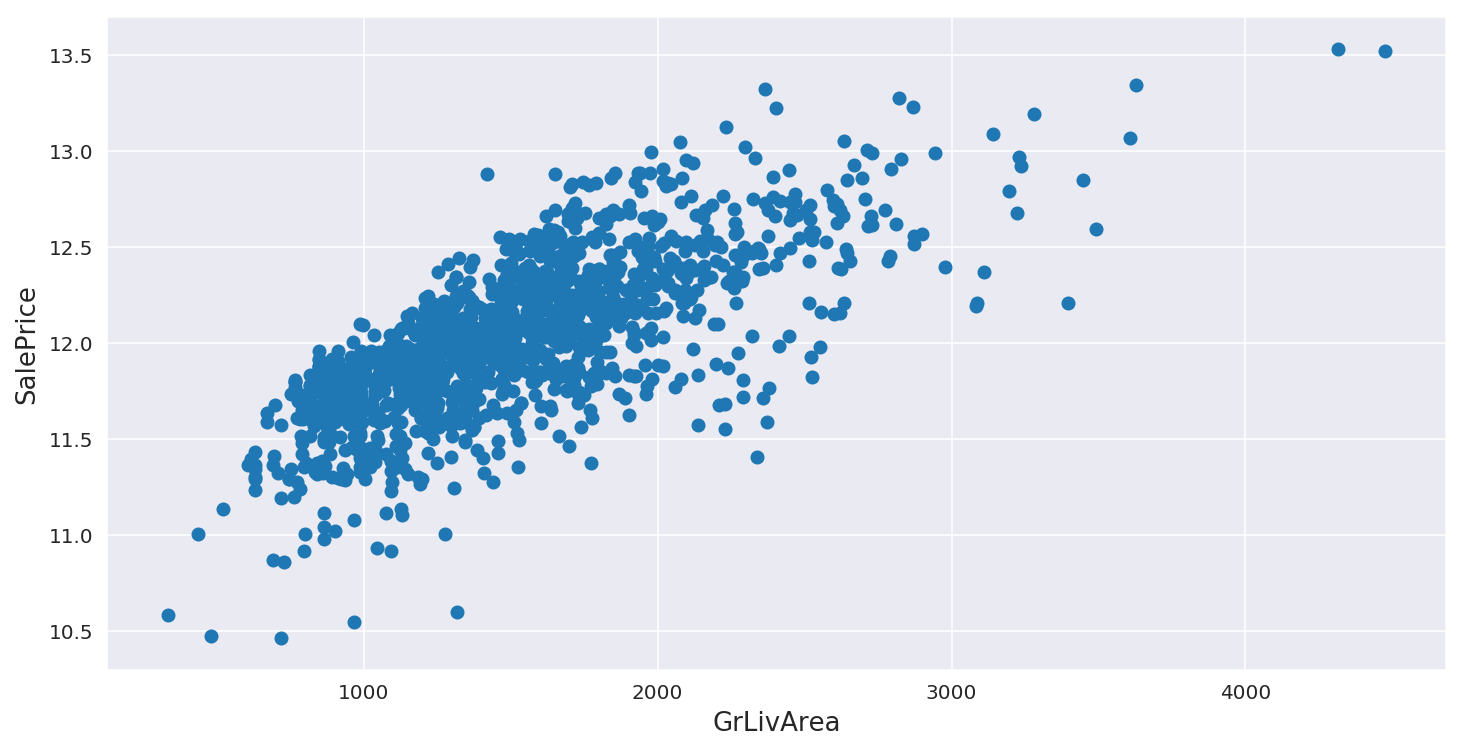

In [38]:
fig, ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train['SalePrice'])
plt.ylabel("SalePrice", fontsize = 13)
plt.xlabel("GrLivArea", fontsize = 13)
plt.show()

## 4.3 缺失值分析及处理

In [70]:
total = train \
    .isnull() \
    .sum() \
    .sort_values(ascending = False)

percent = (train.isnull().sum() / train.isnull().count()) \
    .sort_values(ascending = False)

missing_data = pd.concat([total, percent], 
                         axis = 1, 
                         keys = ["Total", "Percent"])

missing_data[missing_data["Total"] > 0]

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageCond,81,0.055
GarageType,81,0.055
GarageYrBlt,81,0.055
GarageFinish,81,0.055


### 缺失情况1:

变量:

* PoolQC
* MiscFeature
* Alley
* Fence
* FireplaceQu
* LotFrontage

### 缺失情况2:

变量:

* GarageCond
* GarageType
* GarageYrBlt
* GarageFinish
* GarageQual

### 缺失情况3:

## 4.4 数值变量分析及处理

### 4.4.1 将 train 和 test 合并起来,方便数据探索性分析和清洗:

In [21]:
frames = [train.loc[:, "MSSubClass":"SaleCondition"], test.loc[:, "MSSubClass":"SaleCondition"]]
data = pd.concat(frames, axis = 0)
data.shape

(2917, 79)

In [22]:
data.head(6)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000,0.000,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000,1.000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000,Unf,0.000,434.000,920.000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.000,0.000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2.000,608.000,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000,Unf,0.000,540.000,756.000,GasA,Gd,Y,SBrkr,961,756,0,1717,1.000,0.000,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3.000,642.000,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000,Unf,0.000,490.000,1145.000,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.000,0.000,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3.000,836.000,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.000,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732.000,Unf,0.000,64.000,796.000,GasA,Ex,Y,SBrkr,796,566,0,1362,1.000,0.000,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.000,Unf,2.000,480.000,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal


### 4.4.2 将数值变量和类别性变量分开

In [23]:
# 特征的数据类型
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(data.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object


In [73]:
numeric_features = data.dtypes[data.dtypes != 'object'].index
print(numeric_features)
print("共有 %d 个数值型变量!" % len(numeric_features))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
共有 36 个数值型变量!


In [25]:
categorical_features = data.dtypes[data.dtypes == 'object'].index
categorical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

### 4.4.3 数值变量分布偏度分析

数值变量偏度及偏度超过0.75的特征,并将其进行对数转换:

In [26]:
features_skew = data[numeric_features] \
    .apply(lambda x: skew(x.dropna())) \
    .sort_values(axis = 0, ascending = False)
features_skew

MiscVal         21.940
PoolArea        17.689
LotArea         13.109
LowQualFinSF    12.085
3SsnPorch       11.372
KitchenAbvGr     4.301
BsmtFinSF2       4.144
EnclosedPorch    4.002
ScreenPorch      3.945
BsmtHalfBath     3.928
MasVnrArea       2.609
OpenPorchSF      2.529
WoodDeckSF       1.845
MSSubClass       1.375
1stFlrSF         1.257
LotFrontage      1.121
GrLivArea        1.069
BsmtFinSF1       0.980
BsmtUnfSF        0.920
2ndFlrSF         0.862
TotRmsAbvGrd     0.749
Fireplaces       0.725
HalfBath         0.697
TotalBsmtSF      0.676
BsmtFullBath     0.621
OverallCond      0.569
BedroomAbvGr     0.327
GarageArea       0.219
MoSold           0.197
OverallQual      0.190
FullBath         0.166
YrSold           0.132
GarageCars      -0.218
GarageYrBlt     -0.381
YearRemodAdd    -0.450
YearBuilt       -0.599
dtype: float64

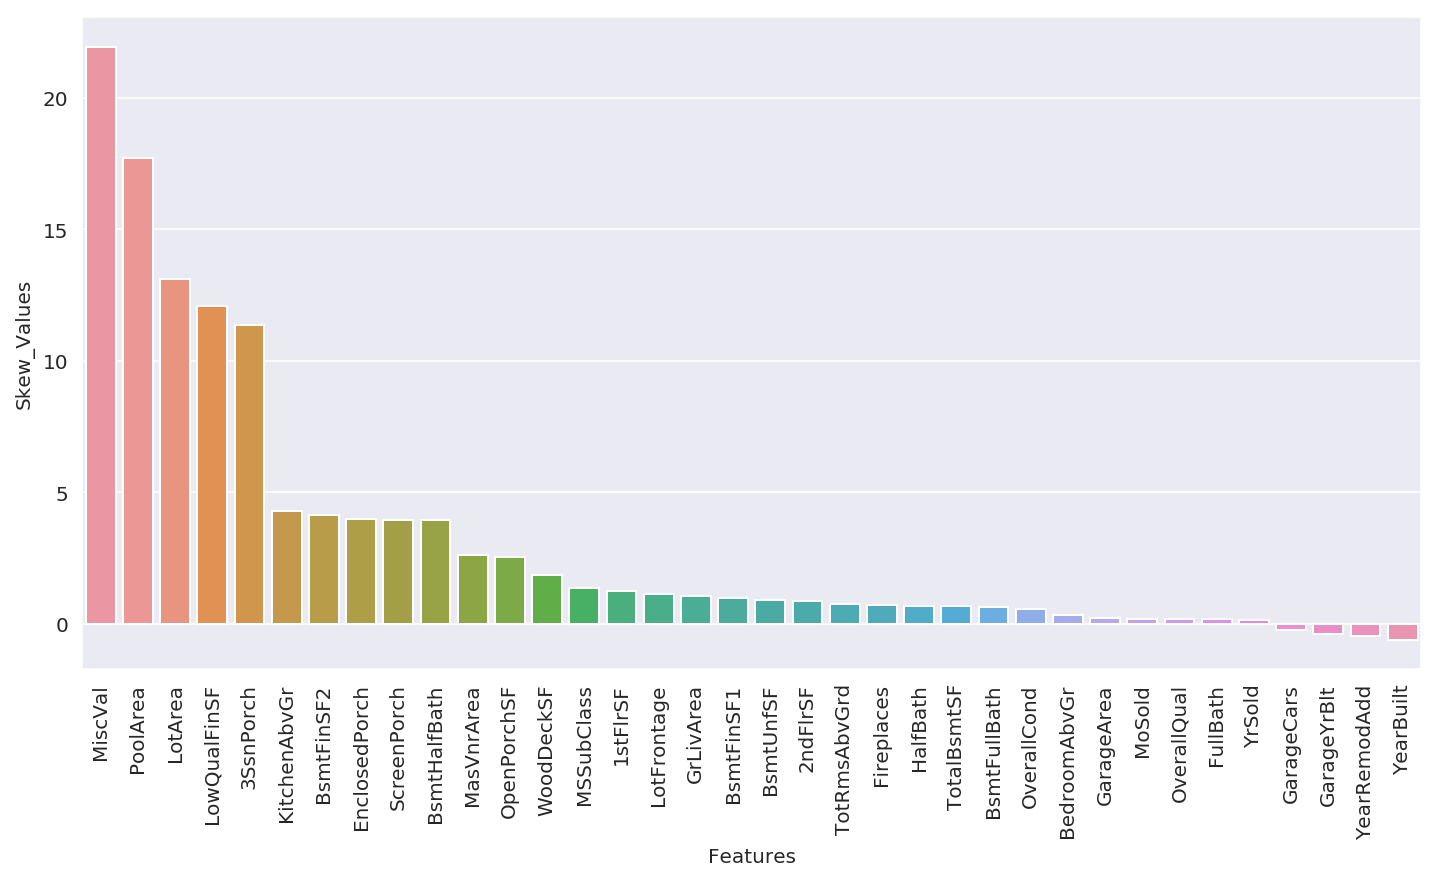

In [27]:
features_skew_df = pd.DataFrame({
    "Features": features_skew.index,
    "Skew_Values": features_skew.values
})
sns.barplot(x = features_skew_df["Features"], 
            y = features_skew_df["Skew_Values"], 
            data = features_skew_df)
plt.xticks(rotation = 90);

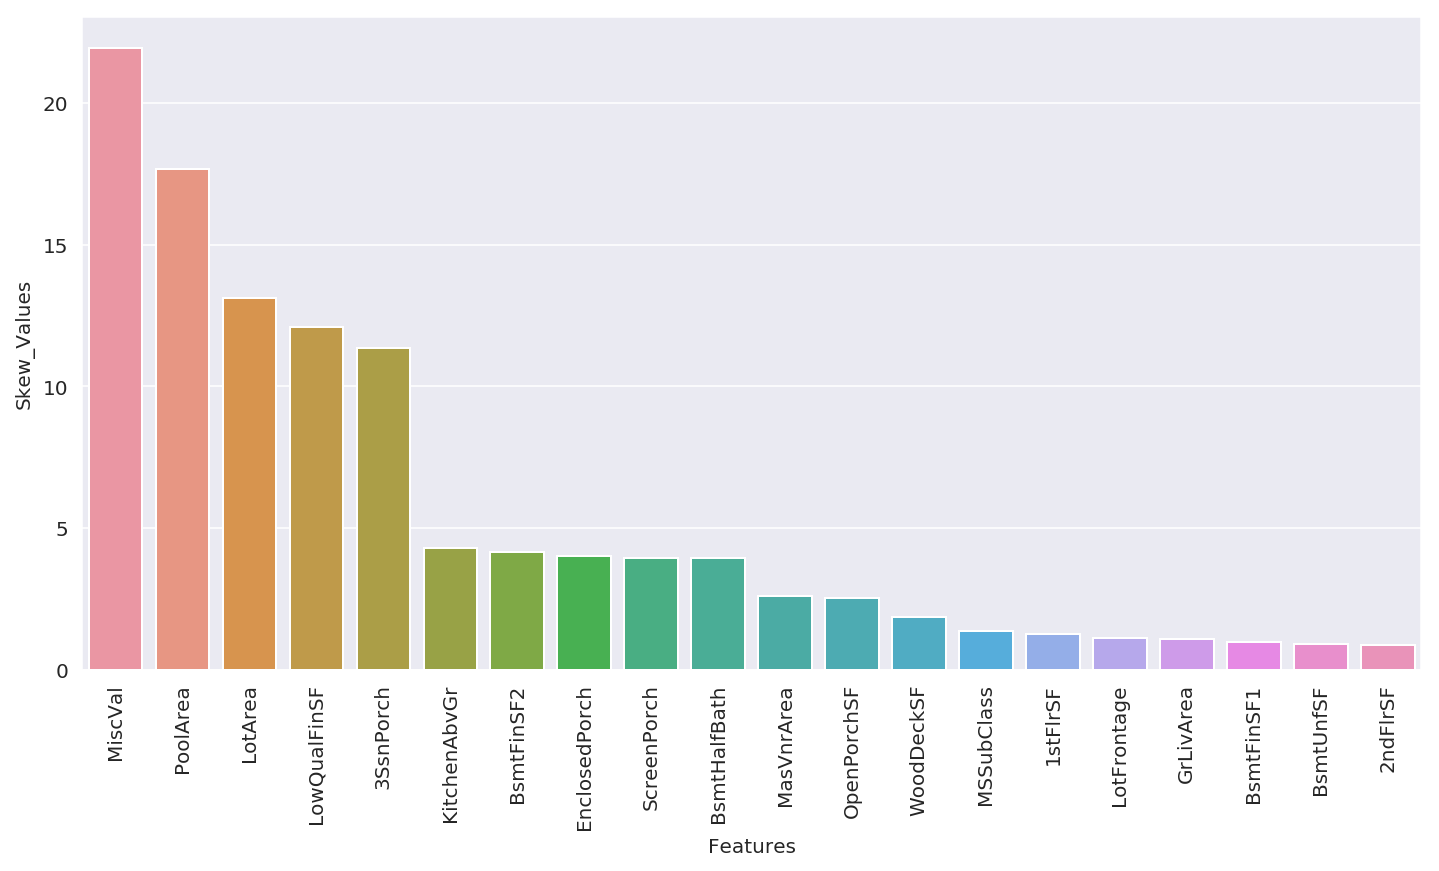

In [28]:
sns.barplot(x = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75]["Features"], 
            y = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75]["Skew_Values"], 
            data = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75])
plt.xticks(rotation = 90);

将偏度超过0.75的特征进行 $log(1 + x)$ 转换:

In [29]:
skewed_features = features_skew[np.abs(features_skew) > 0.75].index
data[skewed_features] = np.log1p(data[skewed_features])

features_skew = data[numeric_features] \
    .apply(lambda x: skew(x.dropna())) \
    .sort_values(axis = 0, ascending = False)
features_skew

PoolArea        15.623
3SsnPorch        8.822
LowQualFinSF     8.555
MiscVal          5.212
BsmtHalfBath     3.772
KitchenAbvGr     3.519
ScreenPorch      2.945
BsmtFinSF2       2.461
EnclosedPorch    1.960
TotRmsAbvGrd     0.749
Fireplaces       0.725
HalfBath         0.697
TotalBsmtSF      0.676
BsmtFullBath     0.621
OverallCond      0.569
MasVnrArea       0.525
BedroomAbvGr     0.327
2ndFlrSF         0.307
MSSubClass       0.246
GarageArea       0.219
MoSold           0.197
OverallQual      0.190
FullBath         0.166
WoodDeckSF       0.160
YrSold           0.132
1stFlrSF         0.030
GrLivArea       -0.022
OpenPorchSF     -0.042
GarageCars      -0.218
GarageYrBlt     -0.381
YearRemodAdd    -0.450
LotArea         -0.533
YearBuilt       -0.599
BsmtFinSF1      -0.618
LotFrontage     -0.900
BsmtUnfSF       -2.158
dtype: float64

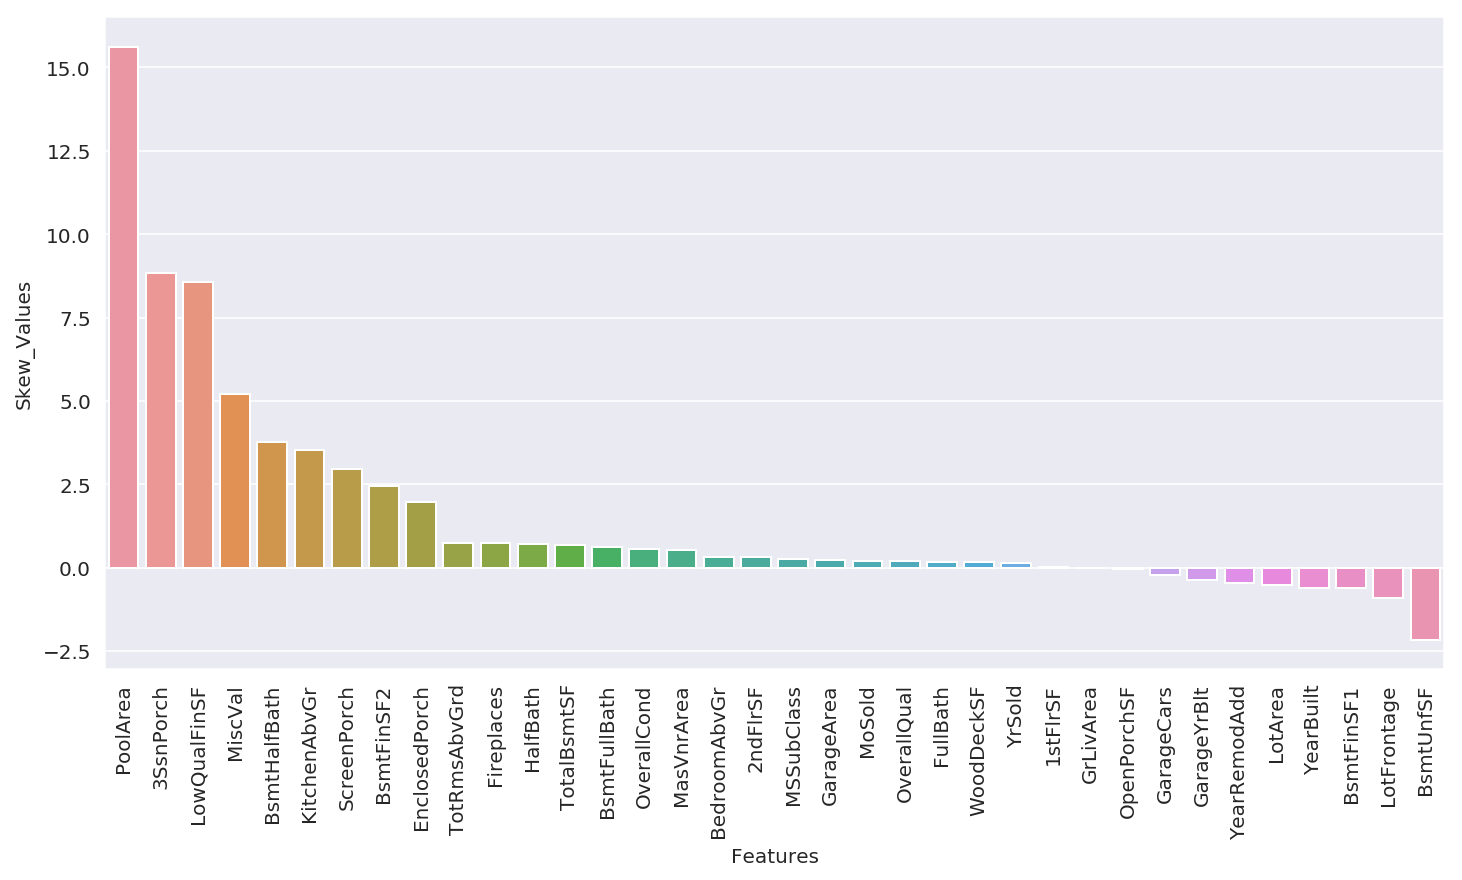

In [30]:
features_skew_df = pd.DataFrame({
    "Features": features_skew.index,
    "Skew_Values": features_skew.values
})
sns.barplot(x = features_skew_df["Features"], 
            y = features_skew_df["Skew_Values"], 
            data = features_skew_df)
plt.xticks(rotation = 90);

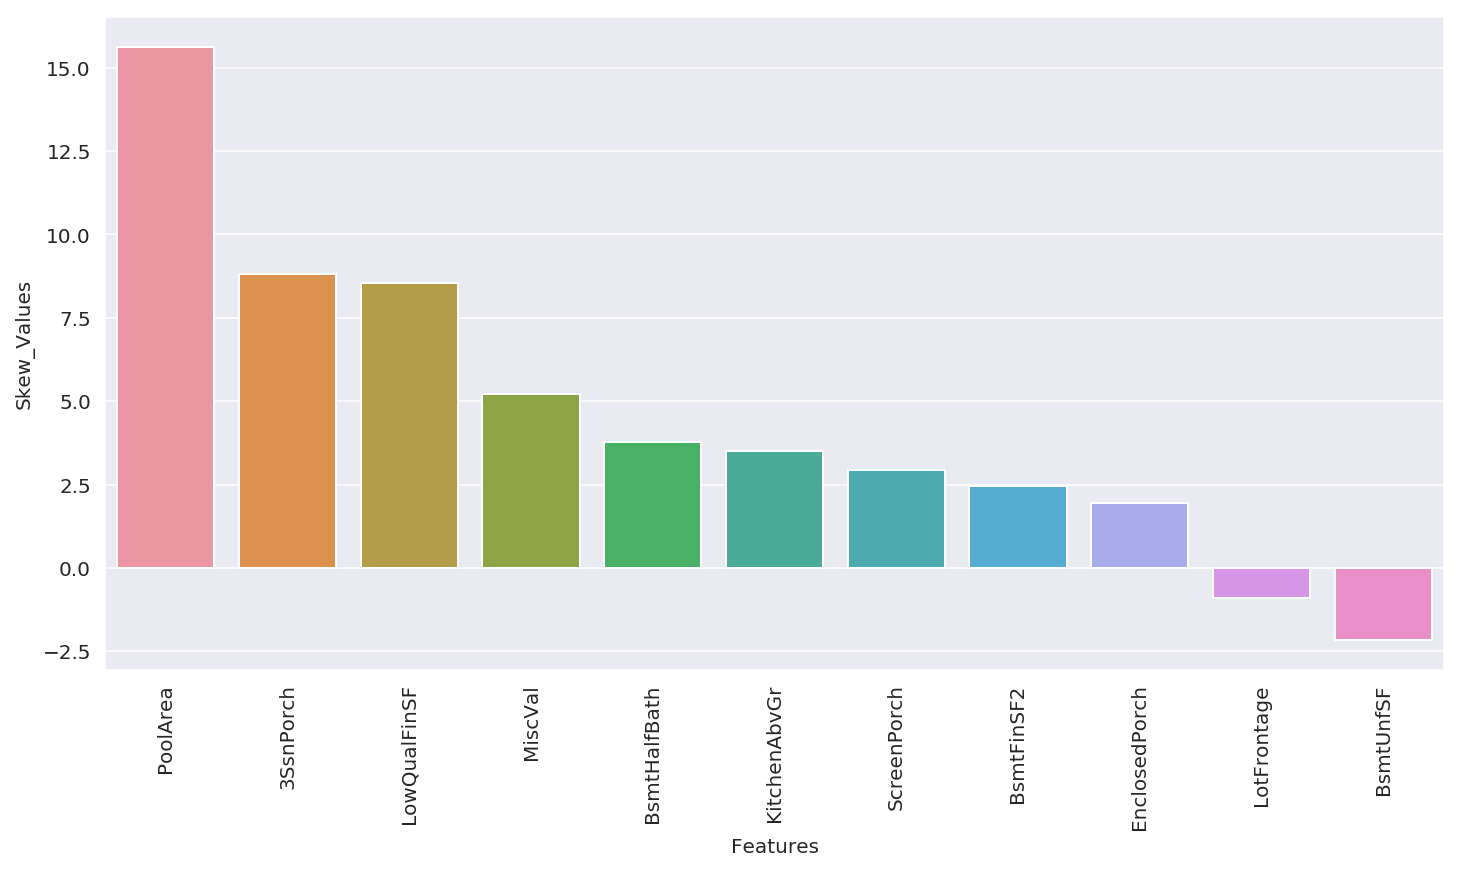

In [31]:
sns.barplot(x = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75]["Features"], 
            y = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75]["Skew_Values"], 
            data = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75])
plt.xticks(rotation = 90);

In [32]:
data[numeric_features].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,4.111,4.190,9.042,7,5,2003,2003,5.283,6.561,0.000,5.017,856.000,6.753,6.751,0.000,7.445,1.000,0.000,2,1,3,0.693,8,0,2003.000,2.000,548.000,0.000,4.127,0.000,0.000,0.000,0.000,0.000,2,2008
1,3.045,4.394,9.170,6,8,1976,1976,0.000,6.887,0.000,5.652,1262.000,7.141,0.000,0.000,7.141,0.000,0.693,2,0,3,0.693,6,1,1976.000,2.000,460.000,5.700,0.000,0.000,0.000,0.000,0.000,0.000,5,2007
2,4.111,4.234,9.328,7,5,2001,2002,5.094,6.188,0.000,6.075,920.000,6.825,6.765,0.000,7.488,1.000,0.000,2,1,3,0.693,6,1,2001.000,2.000,608.000,0.000,3.761,0.000,0.000,0.000,0.000,0.000,9,2008
3,4.263,4.111,9.164,7,5,1915,1970,0.000,5.380,0.000,6.293,756.000,6.869,6.629,0.000,7.449,1.000,0.000,1,0,3,0.693,7,1,1998.000,3.000,642.000,0.000,3.584,5.609,0.000,0.000,0.000,0.000,2,2006
4,4.111,4.443,9.565,8,5,2000,2000,5.861,6.486,0.000,6.196,1145.000,7.044,6.960,0.000,7.696,1.000,0.000,2,1,4,0.693,9,1,2000.000,3.000,836.000,5.263,4.443,0.000,0.000,0.000,0.000,0.000,12,2008


### 4.4.4 类别数据分析及处理

In [33]:
# pd.get_dummies()

# 5.特征工程

# 6.模型数据准备

In [34]:
x_train = data[:train.shape[0]]
x_test = data[train.shape[0]:]
y_train = train.SalePrice

# 7.建模

## 7.1 Linear Regression

In [35]:
from sklearn.linear_model import LinearRegression

## 7.2 Lasso

In [36]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [37]:
def rmse_cv(model, x_train, y_train, cv_method):
    cv_score = cross_val_score(model, x_train, y_train, 
                               scoring = "neg_mean_squared_error", 
                               cv = cv_method)
    rmse = np.sqrt(-cv_score)
    return (rmse)

# alphas = [0.0005, 0.001, 0.1, 1]
# cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
# cv_lasso = pd.Series(cv_lasso, index = alphas)

# cv_lasso.plot(title = 'Validation - Lasso')
# plt.xlabel('alpha')
# plt.ylabel('RMSE')

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
model_lasso.fit(x_train, y)
rmse_cv(model_lasso).mean()

with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    coef = pd.Series(model_lasso.coef_, index = x_train.columns)
    print(coef)

    
print('Lasso picked %s variables and eliminated the other %s variables' % 
      (str(sum(coef != 0)), str(sum(coef == 0))))

pred_lasso = np.expm1(model_lasso.predict(x_test))
pred_lasso

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title('Coefficients in the Lasso Model')

# residuals
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({
    'preds': model_lasso.predict(x_train),
    'true': y
})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter')

NameError: name 'y' is not defined

## 7.3 Ridge Regression

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(model = Ridge(alpha = alpha), x_train = x_train, y = y_train, cv_num = 5).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("RMSE")
cv_ridge.min()
model_ridge = Ridge(alpha = 10)
model_ridge.fit(x_train, y)
pred_ridge = model_ridge.predict(x_test)
pred_ridge

## 7.4 XGBoost Regression

In [ ]:
import xgboost as xgb

In [ ]:
dtrain = xgb.DMatrix(x_train, label = y)
dtest = xgb.DMatrix(x_test)

params = {
    'max_depth': 2,
    'eta': 0.1
}
model = xgb.cv(params, dtrain, num_boost_round = 500, early_stopping_rounds = 100)
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()


model_xgb = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1)
model_xgb.fit(x_train, y)

pred_xgb = np.expm1(model_xgb.predict(x_test))

preds = 0.7 * pred_lasso + 0.3 * pred_xgb


solution = pd.DataFrame({
    'id': test.Id, 
    'SalePrice': preds
})
solution.to_csv('ridge_sol.csv', index = False)

# 8.模型表现比较及结论